打ち切りデータ

In [ ]:
!pip install py4etrics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from py4etrics.truncreg import Truncreg
from py4etrics.tobit import Tobit
from py4etrics.heckit import Heckit
from py4etrics.hetero_test import het_test_probit
from scipy.stats import norm
from statsmodels.formula.api import ols

# 警告メッセージを非表示
import warnings
warnings.filterwarnings("ignore")

In [ ]:
n = 100
threshold = 9 # この値以下のものは打ち切る
intercept = 3

np.random.seed(1)
x = norm.rvs(0, 5, size=n)
y_star = 10*x + intercept + norm.rvs(0, 10, size=n)

y = y_star.copy()
y[y_star < threshold] = threshold

df = pd.DataFrame({'Y':y, 'Y_star':y_star, 'X':x})
df.head()

,Y,Y_star,X
0,79.745983,79.745983,8.121727
1,9.000000,-15.342744,-3.058782
2,9.000000,-19.373671,-2.640859
3,9.000000,-44.712646,-5.364843
4,35.321263,35.321263,4.327038


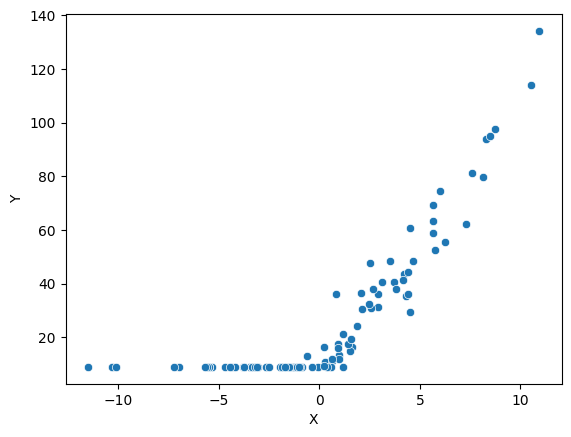

In [ ]:
fig, ax = plt.subplots()
sns.scatterplot(x=df['X'], y=df['Y'])
plt.show()

### トービットモデル

In [ ]:
formula = 'y ~ 1 + x'
cens = df['Y'].apply(lambda x:-1 if x==threshold else 0) # 下限のあるデータのため、データの下限にあたる行に-1を当てるデータを作る
model = Tobit.from_formula(formula, cens=cens, left=threshold, data=df).fit()

Optimization terminated successfully.
         Current function value: 1.860308
         Iterations: 74
         Function evaluations: 140


In [ ]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              Tobit Regression Results                             
===================================================================================
Dep. Variable:                           y   Pseudo R-squ:                    0.380
Method:                 Maximum Likelihood   Log-Likelihood:                 -186.0
No. Observations:                      100   LL-Null:                        -299.9
No. Uncensored Obs:                     51   LL-Ratio:                        227.8
No. Left-censored Obs:                  49   LLR p-value:                     0.000
No. Right-censored Obs:                  0   AIC:                             376.1
Df Residuals:                           98   BIC:                             381.3
Df Model:                                1   Covariance Type:             nonrobust
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.0530      1.781      2.837      0.005       1.562       8.544
x             10.0649      0.397     25.337      0.000       9.286      10.843
Log(Sigma)     2.1407      0.097     22.123      0.000       1.951       2.330
==============================================================================
"""

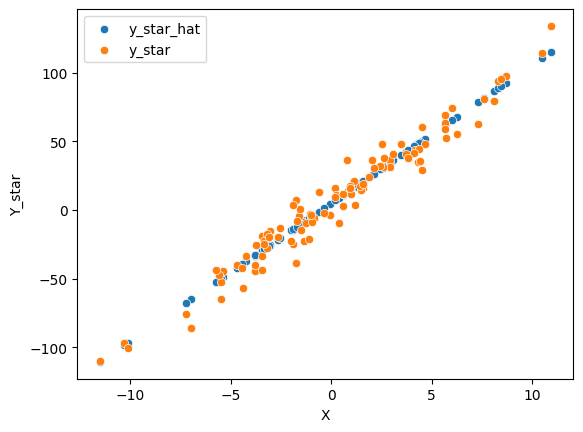

In [ ]:
# 予測値
y_star_hat = model.fittedvalues
fig, ax = plt.subplots()
sns.scatterplot(x=df['X'], y=y_star_hat, label='y_star_hat', ax=ax)
sns.scatterplot(x=df['X'], y=df['Y_star'], label='y_star', ax=ax);

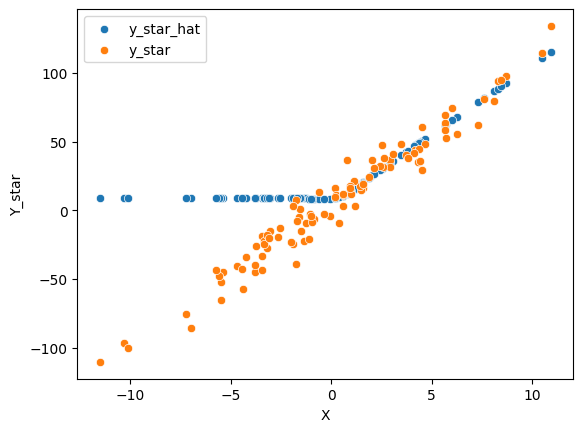

In [ ]:
# xの条件付きの予測値（打ち切り考慮）
y_star_hat = model.fitted_endog
fig, ax = plt.subplots()
sns.scatterplot(x=df['X'], y=y_star_hat, label='y_star_hat', ax=ax)
sns.scatterplot(x=df['X'], y=df['Y_star'], label='y_star', ax=ax);

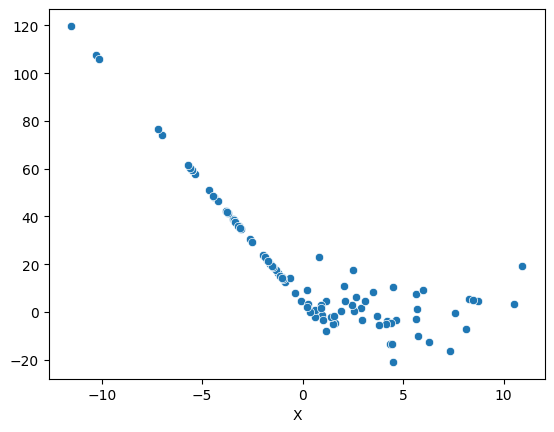

In [ ]:
# 残差
u_hat = model.resid
sns.scatterplot(x=df['X'], y=u_hat);

In [ ]:
import pymc as pm
import arviz as az

In [ ]:
model = pm.Model()

with model:
    Y_data = pm.Data("Y_data", df['Y'], mutable=True)
    X_data = pm.Data('X_data', df['X'], mutable=True)

    # 回帰係数が正規分布に従う
    beta_mu = pm.Normal('beta_mu', mu=0.0, sigma=100.0)
    beta_sigma = pm.HalfNormal('beta_sigma', sigma=100.0)
    beta = pm.Normal('beta', mu=beta_mu, sigma=beta_sigma)

    intercept = pm.Normal('intercept', mu=0.0, sigma=100.0)

    mu = pm.Deterministic('mu', beta*X_data+intercept)
    sigma = pm.HalfNormal("sigma", sigma=100.0)

    normal_dist = pm.Normal.dist(mu=mu, sigma=sigma)
    y_censored = pm.Censored("y_censored", normal_dist, lower=threshold, upper=None, observed=Y_data)

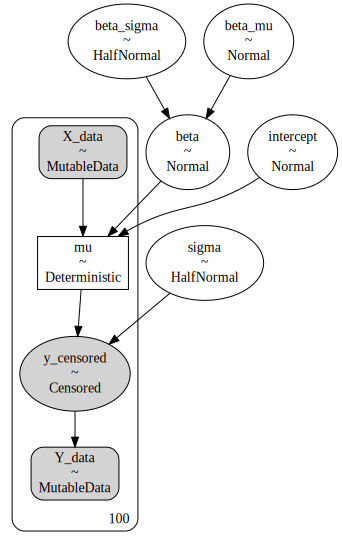

In [ ]:
pm.model_to_graphviz(model)

In [ ]:
with model:
    idata = pm.sample(draws=2000, tune=1000, chains=2, random_seed=42, target_accept=0.995)

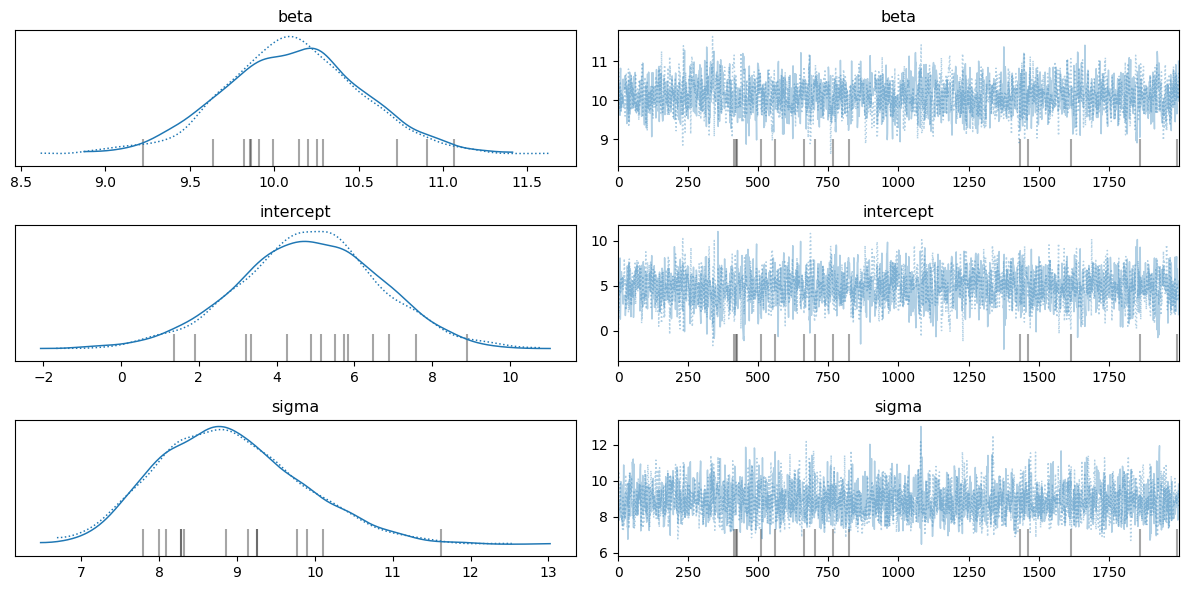

In [ ]:
az.plot_trace(idata, var_names=['beta', 'intercept', 'sigma'])
plt.tight_layout();

In [ ]:
az.summary(idata, var_names=['beta', 'intercept', 'sigma'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta,10.109,0.413,9.369,10.937,0.010,0.007,1843.0,1846.0,1.0
intercept,4.841,1.851,1.259,8.262,0.044,0.031,1769.0,1761.0,1.0
sigma,8.900,0.916,7.284,10.610,0.020,0.014,2238.0,2322.0,1.0


In [ ]:
with model:
    pm.sample_posterior_predictive(idata, extend_inferencedata=True, random_seed=42)

In [ ]:
idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data
	> constant_data

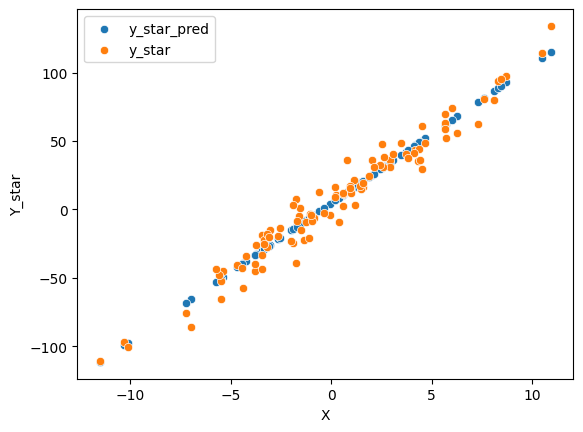

In [ ]:
beta = idata['posterior']['beta'].to_numpy().reshape(-1,)
intercept = idata['posterior']['intercept'].to_numpy().reshape(-1, 1)
X = df['X'].to_numpy()

y_star_pred = np.array([b*X for b in beta]) +intercept
y_star_pred = np.median(y_star_pred, axis=0)

fig, ax = plt.subplots()
sns.scatterplot(x=df['X'], y=y_star_pred, label='y_star_pred', ax=ax)
sns.scatterplot(x=df['X'], y=df['Y_star'], label='y_star', ax=ax);